In [38]:
import pandas as pd
import numpy as np
import seaborn as sns

In [51]:
df = pd.read_csv('imdb_movies.csv')
print("total rows: ", len(df))
df.head()

total rows:  10178


,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,2.716167e+08,AU
1,Avatar: The Way of Water,12/15/2022,78.0,"Science Fiction, Adventure, Action",Set more than a decade after the events of the...,"Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water,Released,English,460000000.0,2.316795e+09,AU
2,The Super Mario Bros. Movie,04/05/2023,76.0,"Animation, Adventure, Family, Fantasy, Comedy","While working underground to fix a water main,...","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie,Released,English,100000000.0,7.244590e+08,AU
3,Mummies,01/05/2023,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Through a series of unfortunate events, three ...","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias,Released,"Spanish, Castilian",12300000.0,3.420000e+07,AU
4,Supercell,03/17/2023,61.0,Action,Good-hearted teenager William always lived in ...,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell,Released,English,77000000.0,3.409420e+08,US


<Axes: >

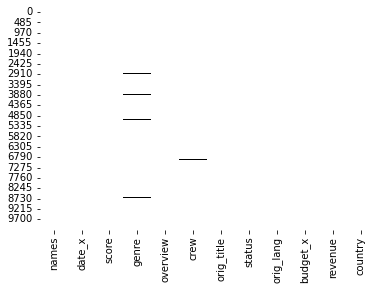

In [52]:
# missing data
sns.heatmap(df.isnull(), cbar=False, cmap='gray_r')

In [53]:
df.dropna(subset=['names','overview'], inplace=True)
df.shape

(10178, 12)

In [54]:
df.head(1)

,names,date_x,score,genre,overview,crew,orig_title,status,orig_lang,budget_x,revenue,country
0,Creed III,03/02/2023,73.0,"Drama, Action","After dominating the boxing world, Adonis Cree...","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III,Released,English,75000000.0,271616668.0,AU


In [55]:
df['text'] = df['names']+' '+df['overview']
df['text']

0        Creed III After dominating the boxing world, A...
1        Avatar: The Way of Water Set more than a decad...
2        The Super Mario Bros. Movie While working unde...
3        Mummies Through a series of unfortunate events...
4        Supercell Good-hearted teenager William always...
                               ...                        
10173    20th Century Women In 1979 Santa Barbara, Cali...
10174    Delta Force 2: The Colombian Connection When D...
10175    The Russia House Barley Scott Blair, a Lisbon-...
10176    Darkman II: The Return of Durant Darkman and D...
10177    The Swan Princess: A Royal Wedding Princess Od...
Name: text, Length: 10178, dtype: object

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
vectorizer = TfidfVectorizer(max_features=10000,
                            stop_words='english',
                            lowercase=True,
                            tokenizer= word_tokenize,)
X = vectorizer.fit_transform(df['text'])
X

c:\Users\ZAID\miniconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<10178x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 254479 stored elements in Compressed Sparse Row format>

In [57]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X, X)
sim.shape

(10178, 10178)

In [58]:
from joblib import dump, load
import os
os.makedirs('models', exist_ok=True)
dump(vectorizer, 'models/vectorizer.joblib')
dump(sim, 'models/similarity.joblib')
df.to_parquet('models/clean_movies.parquet')

In [64]:
def get_id_from_movie(movie_name, df):
    try:return df[df['names'].str.lower()==movie_name.lower()].index.tolist()[0]
    except: return -1

def get_random_movie_from_keyword(keyword, df):
    try: return df[df['overview'].str.lower().str.contains(keyword.lower())].sample(1).index.tolist()[0]
    except: return -1

In [65]:
def get_recommendation(query='', by='name', count=10):
    df = pd.read_parquet('models/clean_movies.parquet')
    sim = load('models/similarity.joblib')
    match by:
        case 'name':
            movie_id = get_id_from_movie(query, df)
            if movie_id == -1:
                return 'Movie not found'
            else:
                sim_scores = list(enumerate(sim[movie_id]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                sim_scores = sim_scores[count+1::-1]
                movie_indices = [i[0] for i in sim_scores]
                return df['names'].iloc[movie_indices].tolist()
        case 'word':
            movie_ids = get_random_movie_from_keyword(query, df)
            if movie_ids == -1:
                return 'Movie not found'
            else:
                sim_scores = list(enumerate(sim[movie_ids]))
                sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
                sim_scores = sim_scores[count+1::-1]
                movie_indices = [i[0] for i in sim_scores]
                return df['names'].iloc[movie_indices].tolist()

In [66]:
get_recommendation('The Dark Knight', count=10)

['Batman: The Killing Joke',
 'Batman: Gotham by Gaslight',
 'Batman: The Dark Knight Returns, Part 2',
 'Batman: Mask of the Phantasm',
 'Batman vs. Two-Face',
 'Batman: The Dark Knight Returns, Part 1',
 'Batman',
 'Batman Beyond: Return of the Joker',
 'The Dark Knight Rises',
 'Batman: The Long Halloween, Part One',
 'Batman: The Long Halloween, Part Two',
 'The Dark Knight']

In [69]:
get_recommendation('Knight', by='word', count=10)

['Bāhubali 2: The Conclusion',
 'ODDTAXI in the Woods',
 'The Redeem Team',
 'Pleasure',
 'Animal House',
 'Team America: World Police',
 'Black Hawk Down',
 'The Delta Force',
 'Red Tails',
 'Delta Force 2: The Colombian Connection',
 'Macross: Do You Remember Love?',
 'Macross Δ the Movie: Passionate Walküre']